In [10]:
import os  # 用於文件操作
import cv2  # 用於影像處理
import math  # 用於數學運算
import numpy as np  # 用於數值運算
import pandas as pd  # 用於數據處理
import joblib  # 用於保存和加載資料縮放器
import matplotlib.pyplot as plt  # 用於繪圖
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime  # 用於時間操作
from sklearn.preprocessing import MinMaxScaler  # 用於資料縮放
import matplotlib.font_manager as fm

import tensorflow as tf  # 用於構建模型
from tensorflow.keras import backend as K  # 用於自定義損失函數

jheng_hei_b_font = fm.FontProperties(fname=r'..\fonts\微軟正黑體_粗體.ttc')
jheng_hei_font = fm.FontProperties(fname=r'..\fonts\微軟正黑體_標準.ttc')

In [11]:
SPLIT_DATA_MODE = 'sequence'  # 數據分割模式 sequence or month
LATITUDE = 'Latitude'
LONGITUDE = 'Longitude'
WINDOW_SIZE = 3
STEP_SIZE = 1
# CELL_DATASET_PATH = r'E:\YuCheng\cell_data_processed\cells'
CELL_DATASET_PATH = r'H:\cell_data_processed\cells'
SCALER_PATH = rf'config\sequence\lstm_multitask_scaler.gz'
MODEL_PATH = rf'weights\sequence\lstm_multitask-scaler_y\lstm_mt_3-1_e06v0.0015'

In [12]:
# ============= 均方根誤差 =============
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# ============= 讀取模型 =============
def load_model(model_path: str, custom_objects: dict = None) -> tf.keras.models.Model:
    if custom_objects is None:
        return tf.keras.models.load_model(model_path)
    return tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# ============= 讀取scaler =============
def load_scaler(scaler_path: str) -> joblib.load:
    return joblib.load(scaler_path)

# ============= 讀取資料 =============
def read_data(start_date: str, end_date: str, scaler: MinMaxScaler) -> tuple:
    print(f'個案日期 {start_date} ~ {end_date}')
    def parse_datetime(date_str: str, is_end: bool = False) -> str:
        try:
            dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            return dt.strftime('%Y%m%d%H%M%S')
        except ValueError:
            dt = datetime.strptime(date_str, '%Y-%m-%d')
            return dt.strftime('%Y%m%d') + ('235959' if is_end else '000000')

    start_date = parse_datetime(start_date, is_end=False)
    end_date = parse_datetime(end_date, is_end=True)

    print(f'開始日期: {start_date}, 結束日期: {end_date}')

    cell_files = sorted(os.listdir(CELL_DATASET_PATH))

    # 原始數值資料，每一個元素是一個DataFrame，每一個DataFrame是一個cell的數值序列
    dataset = []
    original_dataset = []
    # LSTM 輸入資料
    lstm_input_dataset = []

    for cell_file in cell_files:
        cell_file_path = os.path.join(CELL_DATASET_PATH, cell_file)
        date_part, time_part = cell_file.split(
            '_')[0].split('-')  # '20210101', '000000'
        dt = datetime.strptime(date_part + time_part, '%Y%m%d%H%M%S')
        target_date = dt.strftime('%Y%m%d%H%M%S')

        if not (start_date <= target_date <= end_date):
            continue

        # ============= 處理單一個數值序列資料 =============
        # 讀取CSV數據並計算差值
        cell_data = pd.read_csv(cell_file_path, encoding='utf-8',
                                dtype={'FileName': str, 'Date': str, 'Time': str, 'DateTime': str})

        # 經緯度資料
        data = cell_data[[LATITUDE, LONGITUDE]]

        # 提取經度和緯度值
        lat = cell_data[LATITUDE]
        lng = cell_data[LONGITUDE]
        combined_data = np.vstack([lat.values, lng.values]).T  # 經緯度合併

        # 使用scaler對資料進行縮放
        scaled_data = scaler.transform(combined_data)
        
        dataset.append(cell_data)
        original_dataset.append(data)
        lstm_input_dataset.append(scaled_data)

    return (dataset, original_dataset, lstm_input_dataset)

In [13]:
# ============= 預測路徑 =============
def predict_path(model: tf.keras.models.Model, dataset_components: tuple) -> np.array:
    dataset, original_dataset, lstm_input_dataset = dataset_components

    pred_dict = {}  # 用經緯度預測結果
    true_dict = {}  # 用經緯度真實結果

    for i, data in enumerate(dataset):

        pred = []  # [(lat, lng), (lat, lng), ...]
        true = []  # [(lat, lng), (lat, lng), ...]

        for j in range(0, len(lstm_input_dataset[i]) - WINDOW_SIZE, 1):
            # 準備 LSTM 和 ConvLSTM 輸入數據
            lstm_input = np.expand_dims(
                np.array(lstm_input_dataset[i][j: j + WINDOW_SIZE], dtype=np.float32), axis=0)

            input_data = lstm_input

            # 預測經緯度差分
            lat_pred_scaled, lng_pred_scaled = model.predict(input_data)

            # 組成一筆 (1, 2) 的縮放後差分資料
            combined_scaled = np.hstack(
                [lat_pred_scaled, lng_pred_scaled])  # shape = (1, 2)
            # 還原
            inversed = scaler.inverse_transform(combined_scaled)

            pred_lat = inversed[0][0]
            pred_lng = inversed[0][1]

            # 獲取真實經緯度差分
            true_lat = original_dataset[i][LATITUDE].values[j + WINDOW_SIZE]
            true_lng = original_dataset[i][LONGITUDE].values[j + WINDOW_SIZE]

            pred.append((pred_lat, pred_lng))
            true.append((true_lat, true_lng))

        pred_dict[i] = pred
        true_dict[i] = true

    return dataset, pred_dict, true_dict

In [ ]:
def plot_path(dataset: list, pred_dict: dict) -> None:
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())  # 經緯度座標系

    # =================== 統計所有經緯度的最大最小值 ===================
    all_lats = []
    all_lngs = []

    for i, data in enumerate(dataset):
        lats = np.array(data[LATITUDE])
        lngs = np.array(data[LONGITUDE])
        all_lats.extend(lats)
        all_lngs.extend(lngs)

        for pred in pred_dict[i]:
            pred_lat, pred_lng = pred
            all_lats.append(pred_lat)
            all_lngs.append(pred_lng)

    min_lat, max_lat = min(all_lats), max(all_lats)
    min_lng, max_lng = min(all_lngs), max(all_lngs)

    # =================== 繪圖開始 ===================
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # 設定經緯度邊界，加 buffer
    lat_buffer = (max_lat - min_lat) * 0.05
    lng_buffer = (max_lng - min_lng) * 0.05
    # ax.set_extent([min_lng - lng_buffer, max_lng + lng_buffer,
    #                min_lat - lat_buffer, max_lat + lat_buffer], crs=ccrs.PlateCarree())

    # '梅雨鋒面個案_2021-05-30'   # min_lat, max_lat = 23.45, 26.5
    # min_lng, max_lng = 119.8, 123.8
    # extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    # ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_extent([119.8001659, 123.8208661, 23.81446730319214, 26.75911663296509], crs=ccrs.PlateCarree())


    # '午後對流個案_2022-08-25'
    # min_lat, max_lat = 23.25, 25.75
    # min_lng, max_lng = 119.75, 122.5
    # extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    # print(f'設定經緯度範圍: {extent}')
    # ax.set_extent(extent, crs=ccrs.PlateCarree())

    # '烟花颱風個案_2021-07-22'
    # min_lat, max_lat = 22.75, 27.45
    # min_lng, max_lng = 120.15, 124.15
    # extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    # print(f'設定經緯度範圍: {extent}')
    # ax.set_extent(extent, crs=ccrs.PlateCarree())


    # 設定 X、Y 軸刻度（每隔 0.5 度一格可調整）
    x_ticks = np.round(np.arange(min_lng, max_lng + 0.1, 0.5), 2)
    y_ticks = np.round(np.arange(min_lat, max_lat + 0.1, 0.5), 2)
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)

    # 可選：顯示經緯度刻度線
    ax.gridlines(draw_labels=False, linewidth=0.5,
                 color='gray', alpha=0.5, linestyle='--')

    # =================== 畫實際與預測軌跡 ===================
    for i, data in enumerate(dataset):
        latitudes = list(np.array(data[LATITUDE]))
        longitudes = list(np.array(data[LONGITUDE]))

        pred_latitudes = [pred[0] for pred in pred_dict[i]]
        pred_longitudes = [pred[1] for pred in pred_dict[i]]

        plt.plot(longitudes, latitudes, marker='o',
                 markersize=1.5, color='#1f77b4', linewidth=.5)
        plt.plot(pred_longitudes, pred_latitudes, marker='o',
                 markersize=1.5, color='#ff7f0e', linewidth=.5)

    plt.legend(['真實路徑', '預測路徑'], prop=jheng_hei_font, fontsize=8)
    # plt.title(f'LSTM 預測路徑', fontproperties=jheng_hei_b_font, fontsize=14)
    plt.xlabel('經度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.ylabel('緯度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.tight_layout()
    plt.show()

In [15]:
import math
from haversine import haversine

# ============= 評估主函式（輸入3預測1） =============
def evaluate(dataset: list, pred_dict: dict) -> None:
    # ===== 還原位置誤差（預測累積差加回基準位置） =====
    lat_errors = []
    lng_errors = []
    distances = []

    for i, data in enumerate(dataset):
        latitudes = np.array(data['Latitude'])
        longitudes = np.array(data['Longitude'])

        for j, preds in enumerate(pred_dict[i]):
            real_lat = latitudes[j + WINDOW_SIZE]
            real_lng = longitudes[j + WINDOW_SIZE]

            pred_lat, pred_lng = preds

            # 全體誤差
            lat_errors.append(real_lat - pred_lat)
            lng_errors.append(real_lng - pred_lng)
            distances.append(
                haversine((real_lat, real_lng), (pred_lat, pred_lng)),
            )

    # ========= 全部預測誤差 =========
    lat_mae_pos = np.mean(np.abs(lat_errors))
    lng_mae_pos = np.mean(np.abs(lng_errors))
    lat_mse_pos = np.mean(np.square(lat_errors))
    lng_mse_pos = np.mean(np.square(lng_errors))
    lat_rmse_pos = np.sqrt(lat_mse_pos)
    lng_rmse_pos = np.sqrt(lng_mse_pos)
    avg_distance = np.mean(distances)

    print("=== 經緯度位置（還原後）總體評估 ===")
    print(f'Latitude MSE: {lat_mse_pos:.6f} 度')
    print(f'Longitude MSE: {lng_mse_pos:.6f} 度')
    print(f'Latitude MAE: {lat_mae_pos:.6f} 度')
    print(f'Longitude MAE: {lng_mae_pos:.6f} 度')
    print(f'Latitude RMSE: {lat_rmse_pos:.6f}')
    print(f'Longitude RMSE: {lng_rmse_pos:.6f}')
    print(f'Average Haversine distance error: {avg_distance:.6f} km\n')

    return distances

--------------模型讀取成功--------------
個案日期 2021-05-30 04:00:00 ~ 2021-05-30 10:00:00
開始日期: 20210530040000, 結束日期: 20210530100000
1/1 [==============================] - 0s 16ms/step


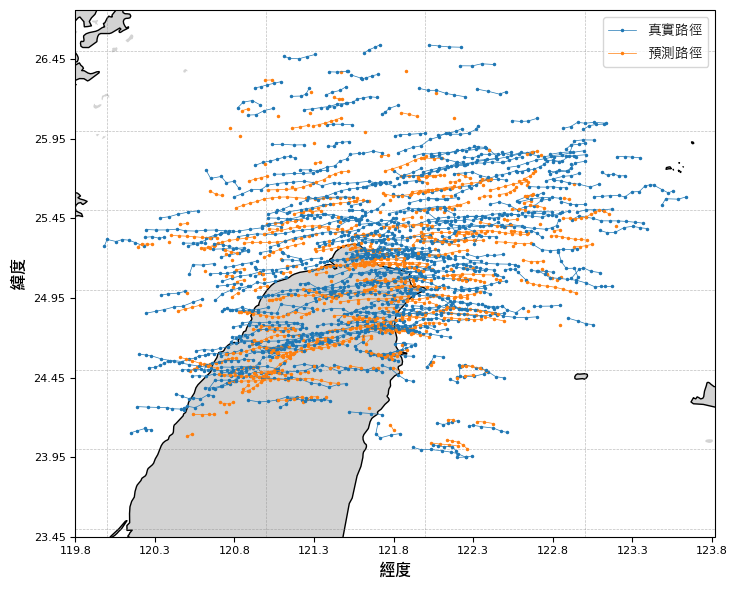

=== 經緯度位置（還原後）總體評估 ===
Latitude MSE: 0.007723 度
Longitude MSE: 0.027786 度
Latitude MAE: 0.072794 度
Longitude MAE: 0.144551 度
Latitude RMSE: 0.087883
Longitude RMSE: 0.166692
Average Haversine distance error: 17.004605 km



In [16]:
# 測試集資料範圍: 2022-07-01 ~ 2022-08-31 可按照需求調整
# start_date = '2022-10-04'
# end_date = '2022-10-04'
# start_date = '2022-12-06'
# end_date = '2022-12-06'

# 不知道甚麼天氣 要查
# start_date = '2022-11-27'
# end_date = '2022-11-29'
# 東北鋒
# start_date = '2022-05-30'
# end_date = '2022-05-30'
# ===================================
# # 2021-01-16  冬季降雨個案(不太好看)
# start_date = '2021-01-16 06:00:00'
# end_date = '2021-01-16 12:00:00'
# # 2021-05-30  梅雨鋒面個案
start_date = '2021-05-30 04:00:00'
end_date = '2021-05-30 10:00:00'
# # 2022-08-25  午後對流個案(很短很小)
# start_date = '2022-08-25 05:00:00'
# end_date = '2022-08-25 11:00:00'
# # 2021-07-22  烟花颱風個案(先不要)
# start_date = '2021-07-22 06:00:00'
# end_date = '2021-07-22 12:00:00'
# # 2022-09-04  軒嵐諾颱風
# start_date = '2022-09-04 11:00:00'
# end_date = '2022-09-04 17:00:00'
# ===================================

# 讀取模型
model = load_model(model_path=MODEL_PATH, custom_objects={'rmse': rmse})

print('--------------模型讀取成功--------------')

# 讀取資料縮放器
scaler = load_scaler(scaler_path=SCALER_PATH)

# 讀取資料(原始數值資料，原始經緯度資料，LSTM輸入數據，ConvLSTM輸入數據)
dataset_components = read_data(
    start_date=start_date,
    end_date=end_date,
    scaler=scaler
)

# 預測路徑
dataset, pred_dict, true_dict = predict_path(model, dataset_components)

# 繪製預測路徑與真實路徑
plot_path(dataset, pred_dict)

# 評估模型
distances = evaluate(dataset, pred_dict)
# evaluate(true_dict, pred_dict)

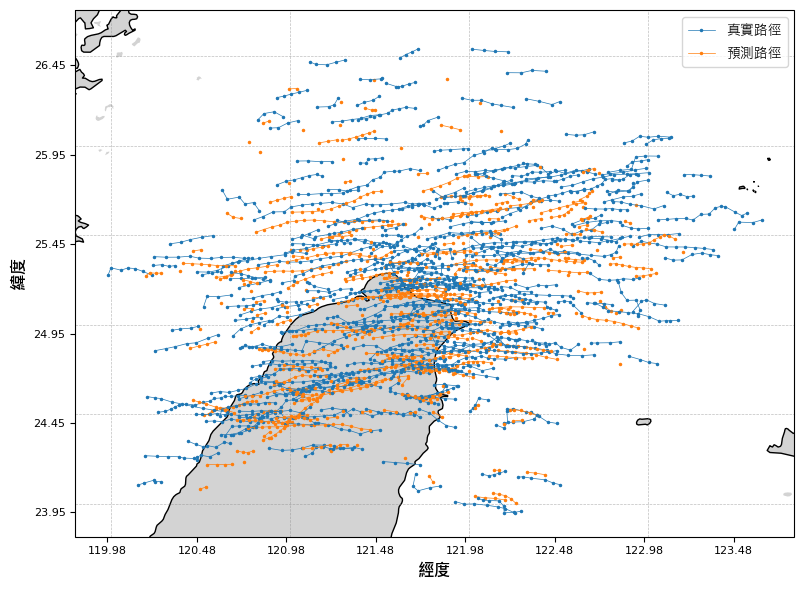

In [24]:
# 繪製預測路徑與真實路徑
plot_path(dataset, pred_dict)

In [ ]:
# import json

# with open('../烟花颱風個案_lstm_haversine_errors.json', 'w', encoding='utf-8') as f:
#     json.dump(distances, f, ensure_ascii=False, indent=2)

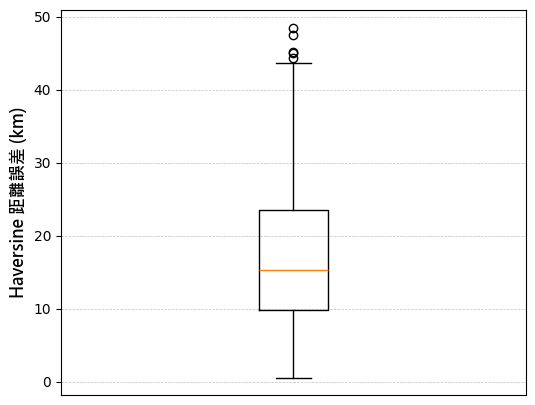

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.figure(figsize=(6, 5))
plt.boxplot(distances)
# plt.title("FFNN Haversine Distance Error Distribution")
plt.ylabel("Haversine 距離誤差 (km)", fontproperties=jheng_hei_b_font, fontsize=12)
plt.xticks([])
plt.grid(True, axis='y', linewidth=0.5, color='gray', linestyle='--', alpha=0.5)
plt.show()

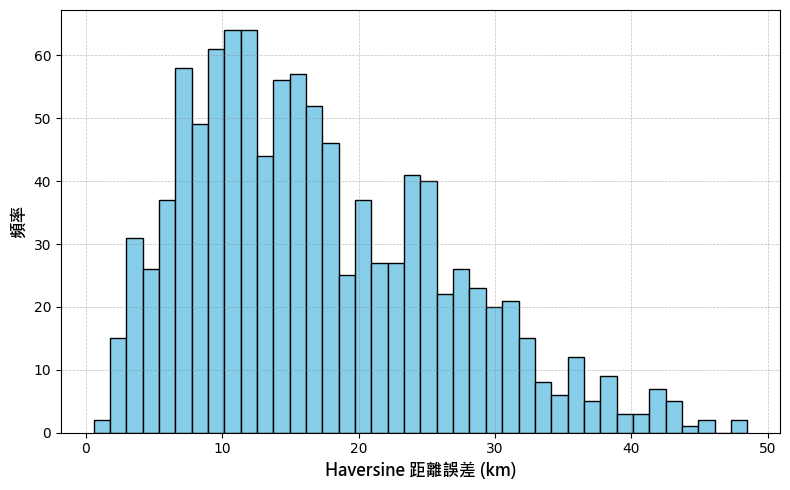

In [ ]:
import matplotlib.pyplot as plt

# 假設 haversine_errors 是一個 numpy array 或 list，單位為 km
plt.figure(figsize=(8, 5))
plt.hist(distances, bins=40, color='skyblue', edgecolor='black')
# plt.title('Haversine Distance Error Histogram')
plt.xlabel('Haversine 距離誤差 (km)', fontproperties=jheng_hei_b_font, fontsize=12)
plt.ylabel('頻率', fontproperties=jheng_hei_b_font, fontsize=12)
plt.grid(True, linewidth=0.5, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# 假設你有這個誤差資料
# haversine_errors = np.array([...])  # 單位為 km

# 自定義誤差區間邊界（可根據需求調整）
bins = [0, 5, 10, 20, 50, 100, np.inf]
labels = ['0–5 km', '5–10 km', '10–20 km', '20–50 km', '50–100 km', '>100 km']

# 分組統計
categories = pd.cut(distances, bins=bins, labels=labels, right=False)
distribution = categories.value_counts().sort_index()
percentages = (distribution / len(distances)) * 100

# 建立結果表格
df = pd.DataFrame({
    '區間': labels,
    '樣本數': distribution.values,
    '比例 (%)': percentages.round(2)
})

# import ace_tools as tools; tools.display_dataframe_to_user(name="誤差分布表（區間分析）", dataframe=df)
df

,區間,樣本數,比例 (%)
0–5 km,0–5 km,61,5.82
5–10 km,5–10 km,210,20.02
10–20 km,10–20 km,427,40.71
20–50 km,20–50 km,351,33.46
50–100 km,50–100 km,0,0.00
>100 km,>100 km,0,0.00


In [ ]:
# # ============= 計算誤差(公里) =============
# def calculate_mae_distance(lat_mae: float, lon_mae: float, latitude: float = 25.071182):
#     lat_km = lat_mae * 111
#     lon_km = lon_mae * 111 * math.cos(math.radians(latitude))
#     return math.sqrt(lat_km**2 + lon_km**2)


# # ============= 評估主函式（輸入3預測1） =============
# def evaluate(true_dict: dict, pred_dict: dict) -> None:
#     lat_errors = []
#     lng_errors = []
#     distances = []

#     for key in true_dict:
#         true_path = true_dict[key]
#         pred_path = pred_dict.get(key)

#         if pred_path is None:
#             continue

#         # 兩邊長度可能不一致，以最短為準
#         if len(true_path) != len(pred_path):
#             print('長度不同，檢查資料')
#             break

#         for i in range(len(true_path)):
#             true_lat, true_lng = true_path[i]
#             pred_lat, pred_lng = pred_path[i]

#             lat_error = pred_lat - true_lat
#             lng_error = pred_lng - true_lng

#             lat_errors.append(lat_error)
#             lng_errors.append(lng_error)

#             # Haversine distance（公里）
#             distance = haversine((true_lat, true_lng), (pred_lat, pred_lng))
#             distances.append(distance)

#     lat_errors = np.array(lat_errors)
#     lng_errors = np.array(lng_errors)
#     distances = np.array(distances)

#     # === 計算誤差指標 ===
#     lat_mse = np.mean(lat_errors ** 2)
#     lng_mse = np.mean(lng_errors ** 2)
#     lat_rmse = np.sqrt(lat_mse)
#     lng_rmse = np.sqrt(lng_mse)
#     lat_mae = np.mean(np.abs(lat_errors))
#     lng_mae = np.mean(np.abs(lng_errors))
#     avg_haversine = np.mean(distances)

#     print(f"=== 經緯度位置誤差統計（度） ===")
#     print(f"Latitude MSE: {lat_mse:.6f} 度")
#     print(f"Longitude MSE: {lng_mse:.6f} 度")
#     print(f"Latitude MAE: {lat_mae:.6f} 度")
#     print(f"Longitude MAE: {lng_mae:.6f} 度")
#     print(f"Latitude RMSE: {lat_rmse:.6f}")
#     print(f"Longitude RMSE: {lng_rmse:.6f}")
#     print(f"Average Haversine distance error: {avg_haversine:.6f} km")